In [3]:
import TrodesReader
from collections import deque
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt

## Filter and RMS functions

In [6]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    """
    Return a dictionary of filtered lfp data

    :param filter_name: name of the filter you want to use
    :type filter_name: string
    :param flattened_array: array of the raw lfp data
    :type flattened_array: np array
    :param sampling_freq: frequency lfp data was sampled at
    :type sampling_freq: int
    :param order: order of filter
    :type order: int
    :param lowcut: lower border of frequencies allowed to pass
    :type lowcut: int
    :param highcut: upper border of frequencies allowed to pass
    :type highcut: int

    :return: filtered lfp data
    :rtype: np array
    """
    if filter_name == 'elliptical':
        sos = signal.ellip(order, 0.01, 120, [lowcut, highcut], btype='bp', output='sos', fs=sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)

    return y

def calculate_rms(buffer):
    """
    return the root mean-squared of a given array
    :param buffer: any array or list of number

    :return: the root mean-squared value of the array as a proxy for its power
    :rtype: float
    """
    square_summed = 0
    for k in buffer:
        square_summed += (k**2)

    return math.sqrt(square_summed/len(buffer))


def filter_then_rms(buffer, low_cut, high_cut, threshold):
    """
    :param buffer: the buffer of lfp data at current iteration
    :param low_cut: the lower bound of the frequency band of interest
    :param high_cut: the upper bound of the frequency band of interest
    :param threshold: the threshold of power for making decision/judgement

    :return: whether there is activity in freq range [low_cut, high_cut] or not
    :rtype: boolean
    """
    filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    current_rms = calculate_rms(filtered_buffer)
    #current_rms = calculate_rms(buffer)
    if current_rms >= threshold:
        return (True, current_rms)
    else:
        return (False, current_rms)
    

def detection_with_rms_no_filter(buffer, low_cut, high_cut, threshold):
    """
    :param buffer: the buffer of lfp data at current iteration
    :param low_cut: the lower bound of the frequency band of interest
    :param high_cut: the upper bound of the frequency band of interest
    :param threshold: the threshold of power for making decision/judgement

    :return: whether there is activity in freq range [low_cut, high_cut] or not
    :rtype: boolean
    """
    #filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    #current_rms = calculate_rms(filtered_buffer)
    current_rms = calculate_rms(buffer)
    if current_rms >= threshold:
        return (True, current_rms)
    else:
        return (False, current_rms)

# LFP data

In [7]:
lfp_sampling_rate = 1250
lfp_sampling_period = (1/1250)*(10**9)
fNQ = 600

data_path = 'X:\\Trodes\\Lab Data\\20211117_testing_5min\\20211117_testing_5min.LFP\\20211117_testing_5min.LFP_nt28ch1.dat'
timestamp_path = 'X:\\Trodes\\Lab Data\\20211117_testing_5min\\20211117_testing_5min.LFP\\20211117_testing_5min.timestamps.dat'

data = TrodesReader.readTrodesExtractedDataFile(data_path)
timestamps = TrodesReader.readTrodesExtractedDataFile(timestamp_path)

lfp_data = []
for i in data['data']:
    lfp_data.append(i[0])

In [14]:
theta_filtered_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, 4, 10)

# Threshold calculation

In [15]:
# Offline threshold
theta_offline = []

for i in range(499,len(theta_filtered_data)):
    theta_buffer = theta_filtered_data[i-499:i]
    theta_offline.append(calculate_rms(theta_buffer))

In [16]:
theta_avg_rms_offline = np.mean(theta_offline)
theta_std_rms_offline = np.std(theta_offline)
theta_threshold_rms_offline = theta_avg_rms + 3*theta_std_rms

print('Average: ' + str(theta_avg_rms_offline))
print('Standard deviation: ' + str(theta_std_rms_offline))
print('Threshold: ' + str(theta_threshold_rms_offline))

Average: 307.3737170817279
Standard deviation: 137.58065257118866
Threshold: 720.1156747952939


In [17]:
# Online threshold
theta_online = []
for i in range(499,len(lfp_data)): 
    buffer_for_thresh = lfp_data[i-499:i]
    theta_filter = bandpass_filter('butterworth', buffer_for_thresh, lfp_sampling_rate, 1, 4, 10)
    theta_online.append(calculate_rms(theta_filter))

In [18]:
theta_avg_rms_online = np.mean(theta_online)
theta_std_rms_online = np.std(theta_online)
theta_threshold_rms_online = theta_avg_rms_online + 3*theta_std_rms_online

print('Average: ' + str(theta_avg_rms_online))
print('Standard deviation: ' + str(theta_std_rms_online))
print('Threshold: ' + str(theta_threshold_rms_online))

Average: 285.60924486058894
Standard deviation: 127.76170545420426
Threshold: 668.8943612232017


# Online/ Live update

In [23]:
theta_decision_list = [False, False]
theta_detection_rms = []
theta_stimulation_list = []

for i in range(499,len(lfp_data)): 
    online_buffer = lfp_data[i-499:i]
    theta_decision = filter_then_rms(online_buffer,4,10,theta_threshold_rms_offline)
    theta_decision_list.append(theta_decision[0])
    theta_detection_rms.append(theta_decision[1])
    
    theta_stimulation = True
    for m in range(len(theta_decision_list)-3, len(theta_decision_list)):
        if theta_decision_list[m] == False:
            theta_stimulation = False
    
    theta_stimulation_list.append(theta_stimulation)

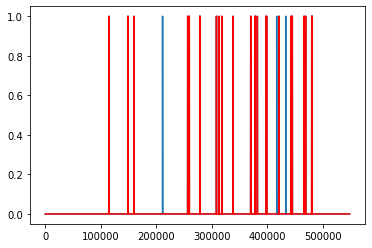

In [24]:
plt.plot(theta_decision_list)
plt.plot(theta_stimulation_list,color='r')
plt.show()

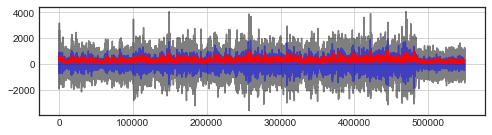

In [54]:
# Filtered data and online RMS
fig6 = plt.figure(figsize=(8,3))
grid = plt.GridSpec(6,1,wspace=0.5, hspace=0)
ax1 = plt.subplot(grid[0:4,0:1])
ax1.plot(lfp_data,color='k',alpha=0.5)
ax1.plot(theta_filtered_data[499:len(theta_filtered_data)],color='b',alpha=0.5)
ax1.plot(theta_detection_rms,color='r')
ax1.grid(True)
plt.style.use('seaborn-white')
plt.show()

# Offline

In [30]:
theta_decision_list_offline = [False, False]
theta_detection_rms_offline = []
theta_stimulation_list_offline = []
for i in range(499,len(theta_filtered_data)):  #raw and theta filtered data have the same length
    offline_buffer = theta_filtered_data[i-499:i]
    theta_offline_decision = detection_with_rms_no_filter(offline_buffer,4,10,theta_threshold_rms_offline)
    theta_decision_list_offline.append(theta_offline_decision[0])
    theta_detection_rms_offline.append(theta_offline_decision[1])
    
    theta_stimulation_offline = True
    for m in range(len(theta_decision_list_offline)-3, len(theta_decision_list_offline)):
        if theta_decision_list_offline[m] == False:
            theta_stimulation_offline = False
    
    theta_stimulation_list_offline.append(theta_stimulation_offline)

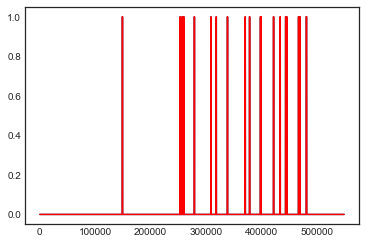

In [31]:
plt.plot(theta_decision_list_offline)
plt.plot(theta_stimulation_list_offline,color='r')
plt.show()

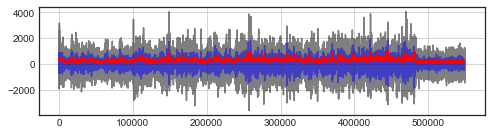

In [55]:
# Filtered data and offline RMS
fig6 = plt.figure(figsize=(8,3))
grid = plt.GridSpec(6,1,wspace=0.5, hspace=0)
ax1 = plt.subplot(grid[0:4,0:1])
ax1.plot(lfp_data,color='k',alpha=0.5)
ax1.plot(theta_filtered_data[499:len(theta_filtered_data)],color='b',alpha=0.5)
ax1.plot(theta_detection_rms_offline,color='r')
ax1.grid(True)
plt.style.use('seaborn-white')
plt.show()

# Offline vs Online

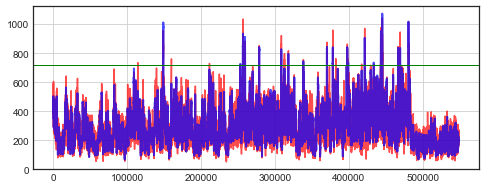

In [33]:
plt.figure(figsize=(8,3))
plt.plot(theta_detection_rms,color='r',alpha=0.7,label='Online RMS')  #buffer then filter
plt.plot(theta_detection_rms_offline, color='b',linewidth=2,alpha=0.7,label='Offline RMS')  #filter then buffer
plt.axhline(y=theta_threshold_rms_offline, color='green',linewidth = '1',label='Threshold')
# plt.legend(fontsize=6)
plt.grid(True)
# plt.ylabel('RMS',fontsize=60)
# plt.xlabel('Sample #',fontsize=60)
plt.show()

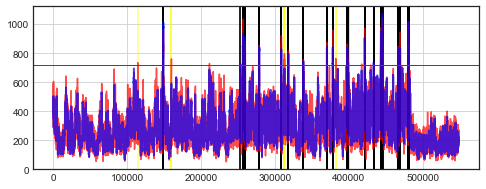

In [34]:
plt.figure(figsize=(8,3))

for s in range(0,len(theta_stimulation_list)):
    if theta_stimulation_list[s]:
        plt.axvline(x=s, color='yellow',alpha=0.5)
        
for s in range(0,len(theta_stimulation_list_offline)):
    if theta_stimulation_list_offline[s]:
        plt.axvline(x=s, color='k',alpha=0.1)
        

plt.plot(theta_detection_rms,color='r',alpha=0.7,label='Online RMS')  #buffer then filter
plt.plot(theta_detection_rms_offline, color='b',linewidth=2,alpha=0.7,label='Offline RMS')  #filter then buffer
plt.axhline(y=theta_threshold_rms_offline, color='green',linewidth = '1',label='Threshold')

plt.grid(True)
# plt.xlabel('Sample #',fontsize=60)
# plt.title('Theta Range Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
# plt.legend(fontsize=60)
plt.show()

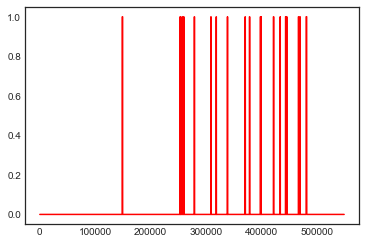

In [41]:
plt.plot(theta_stimulation_list_offline,color='r')
plt.show()

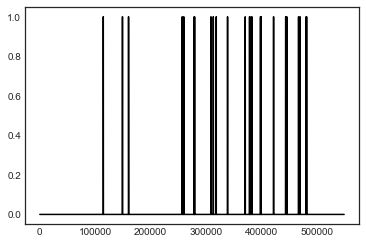

In [40]:
plt.plot(theta_stimulation_list,color='k')
#plt.plot(theta_stimulation_list_offline,color='r')
plt.show()

In [45]:
TP = 0
FP = 0
TN = 0
FN = 0
for i in range(len(theta_stimulation_list_offline)):
    if theta_stimulation_list_offline[i] == True and theta_stimulation_list[i] == True:
        TP += 1
    if theta_stimulation_list_offline[i] == False and theta_stimulation_list[i] == False:
        TN += 1    
    if theta_stimulation_list_offline[i] == False and theta_stimulation_list[i] == True:
        FP += 1
    if theta_stimulation_list_offline[i] == True and theta_stimulation_list[i] == False:
        FN += 1
TP,TN,FP,FN        

(5084, 541226, 38, 2563)

In [43]:
count = 0
for i in range(len(theta_stimulation_list_offline)):
    if theta_stimulation_list_offline[i] ! = theta_stimulation_list[i]:
        count +=1
count

2601

In [52]:
Accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
print("A:",Accuracy)
Precision = TP/(TP+FP)
print("P:",Precision)
Recall = (TP/(TP+FN))*100
print("R:",Recall)

A: 99.52615269141992
P: 99.25810230378758
R: 66.48358833529488
